# Build Structural Topic Model on NEH Grant Products

<b>Author:</b> Jaren Haber, PhD <br>
<b>Date</b>: September 16, 2023 <br>
<b>Description</b>: Preprocesses text, estimates structural topic model, and assesses output of topic/term/gender relationships with emphasis on visualizations. <br>
<b>Sources</b>: Code borrowed from [my team's work here](https://github.com/comp-strat/text_analysis) and [this vignette for STM in R](https://cran.r-project.org/web/packages/stm/vignettes/stmVignette.pdf) <br>
<b>Required packages</b>: `stm`, `texteffect`, `quanteda`, `tm`, `Rtsne`, `rsvd`, `geometry` <br>

## Initialize

In [1]:
install.packages(c("pacman"))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [35]:
# import libraries
pacman::p_load(
    foreign,
    ggplot2,
    tidyr,
    dplyr,
    tm, 
    furrr,
    wordcloud, 
    tidytext, # for tidy text
    tidyverse, 
    stm, # for structural topic modeling
    stmCorrViz, 
    LDAvis, 
    igraph, 
    stringr, 
    quanteda, 
    zoo, 
    tau, 
    knitr, 
    rsvd, 
    magrittr,
    broom, 
    lubridate)

In [3]:
# Set working directory to data folder
setwd('../data/')
getwd()

[1] "/home/jovyan/work/neh-nlp/data"

## Import data

In [4]:
data = read.csv('NEH_GrantProducts_Prepared_w_Gender.tsv', sep='\t')
str(data)

'data.frame':	7108 obs. of  5 variables:
 $ ID         : int  8 21 22 24 29 38 39 45 46 47 ...
 $ Abstract   : chr  "Parallel vetted publication of the NEH sponsored project \"Visualizing Statues in the Late Antique Roman Forum\"" "This comparative study of late nineteenth century Britain and France examines regional and local patterns of ru"| __truncated__ "This comparative spatial history combines historical narrative, geographical thinking, and spatial analysis of "| __truncated__ "One of the early drivers of historical GIS was the development of national historical GISs. These systems usual"| __truncated__ ...
 $ Year       : int  2011 2010 2011 2009 2010 2010 2011 2005 2004 2004 ...
 $ ProductType: chr  "Articles" "Articles" "Articles" "Articles" ...
 $ Gender     : chr  "male" "male" "male" "male" ...


In [5]:
# check whether rows contain any NAs
row.has.na <- apply(data, 1, function(x){any(is.na(x))})
sum(row.has.na)

[1] 0

## Prepare text data

In [6]:
processed <- textProcessor(data$Abstract, metadata = data)

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 


In [7]:
processed

A text corpus with 7098 documents, and an 31291 word dictionary.

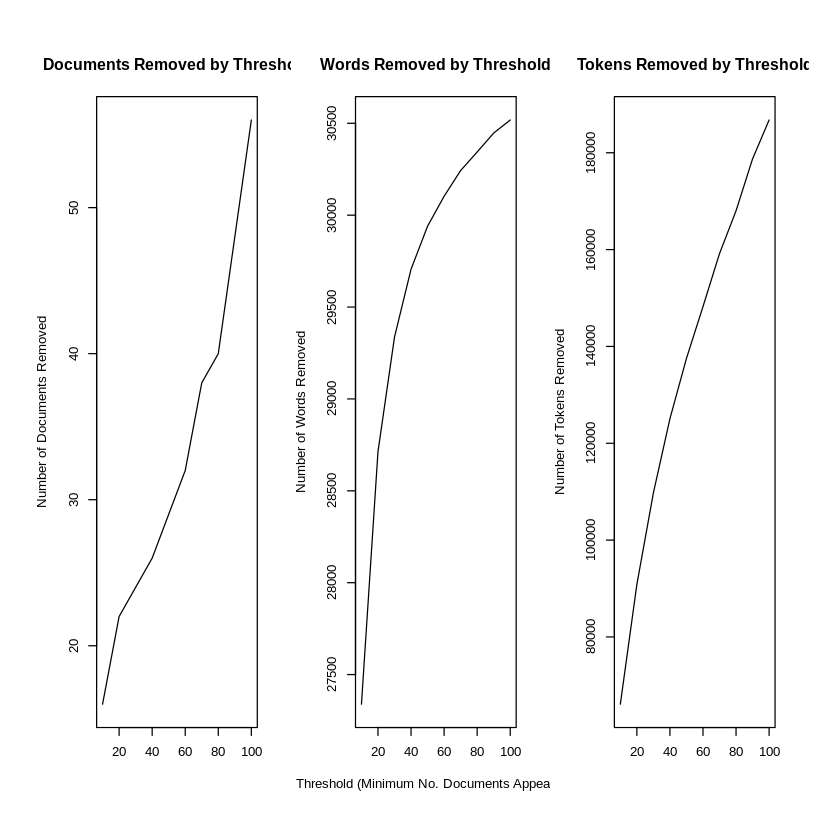

In [8]:
plotRemoved(processed$documents, lower.thresh = seq(10, 100, by = 10))

In [9]:
out <- prepDocuments(processed$documents, processed$vocab, processed$meta, lower.thresh = 3)

Removing 23504 of 31291 terms (31397 of 361677 tokens) due to frequency 
Removing 12 Documents with No Words 
Your corpus now has 7086 documents, 7787 terms and 330280 tokens.

In [10]:
docs <- out$documents
vocab <- out$vocab
meta <- out$meta

## Estimate Structural Topic Model

In [11]:
model <- stm(documents = out$documents, 
             vocab = out$vocab, 
             K = 20, 
             prevalence =~ Year + Gender, 
             max.em.its = 25, 
             data = out$meta, 
             init.type = "Spectral")

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Finding anchor words...
 	....................
	 Recovering initialization...
 	.............................................................................
Initialization complete.
.....................................................................................................
Completed E-Step (2 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -7.781) 
.....................................................................................................
Completed E-Step (2 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -7.576, relative change = 2.632e-02) 
.....................................................................................................
Completed E-Step (2 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -7.466, relative change = 1.453e-02) 
...........................................................

In [12]:
# Save model to disk
save(model, file='../output/topic_model.RData')

## Examine words and example documents

In [13]:
# Shows the top 50 words for each topic according to Highest, FREX, Lift, and Score measures with Frex =.7
top_words <- labelTopics(model, n=50, frexweight = .7)
top_words

Topic 1 Top Words:
 	 Highest Prob: languag, archaeolog, use, site, data, result, word, excav, linguist, analysi, present, paper, ancient, includ, structur, architectur, relat, system, also, can, studi, survey, method, featur, evid, one, find, locat, may, provid, compar, context, larg, dictionari, exampl, identifi, new, construct, audio, remain, corpus, build, two, suggest, type, within, differ, area, techniqu, record 
 	 FREX: archaeolog, languag, linguist, dictionari, excav, site, survey, audio, word, coptic, speaker, data, architectur, corpus, result, structur, grammar, morpholog, locat, spoken, method, type, encod, compar, entri, tag, typolog, season, artifact, system, archaeologist, classif, grammat, speech, analysi, identifi, techniqu, find, ancient, ceram, settlement, paper, egyptian, exampl, maya, reconstruct, may, pattern, preliminari, area 
 	 Lift: amith, edfu, epipalaeolith, faunal, fortif, klallam, lidar, methon, morphosyntact, nahuatl, quechuan, suffix, totonac, yauyo, en

In [62]:
### KNOWN BUG: The next few cells don't work yet

# find the top 3 documents that are most representative for Academics cluster topics
#findThoughtsObj <- findThoughts(model, text=data$Abstract, topics=c(1:20), n=3)

# view the documents
#findThoughtsObj$docs[[1]]

ERROR: Error in findThoughts(model, text = data$Abstract, topics = c(1:20), n = 3): Number of provided texts and number of documents modeled do not match


In [ ]:
# plot the document strings
#plotQuote(findThoughtsObj$docs[[1]], width = 70, text.cex = 1, maxwidth = 300)

In [ ]:
# examine documents that are highly associated with topics
#thoughts <- findThoughts(model, texts = docs, n = 2, topics = 3)$docs[[1]]

In [ ]:
#par(mfrow = c(1, 2),mar = c(.5, .5, 1, .5))

#plotQuote(thoughts, width = 30, main = "Topic 3")

## Visualize STM

png 
  2

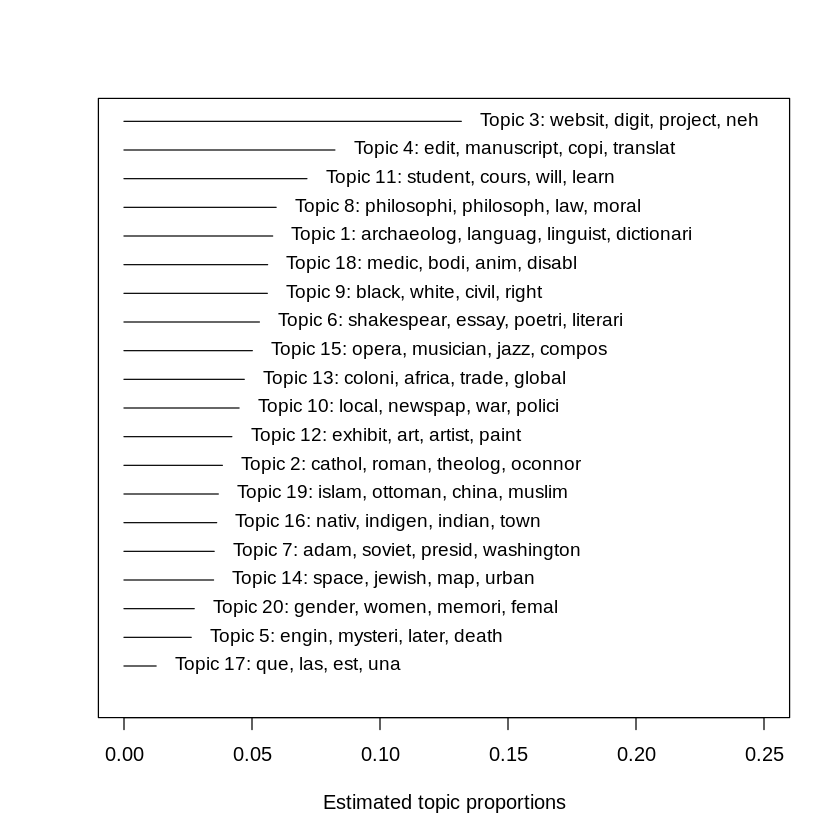

In [30]:
# Graphical display of estimated topic proportions
png(filename='../output/topic_frequencies.png')
plot(model, type = "summary", n = 4, xlim = c(0, 0.25), text.cex = 0.9485, 
     main = "", xlab = "Estimated topic proportions", labeltype = "frex", frexw = 0.7)
dev.off()

plot(model, type = "summary", n = 4, xlim = c(0, 0.25), text.cex = 0.9485, 
     main = "", xlab = "Estimated topic proportions", labeltype = "frex", frexw = 0.7)

png 
  2

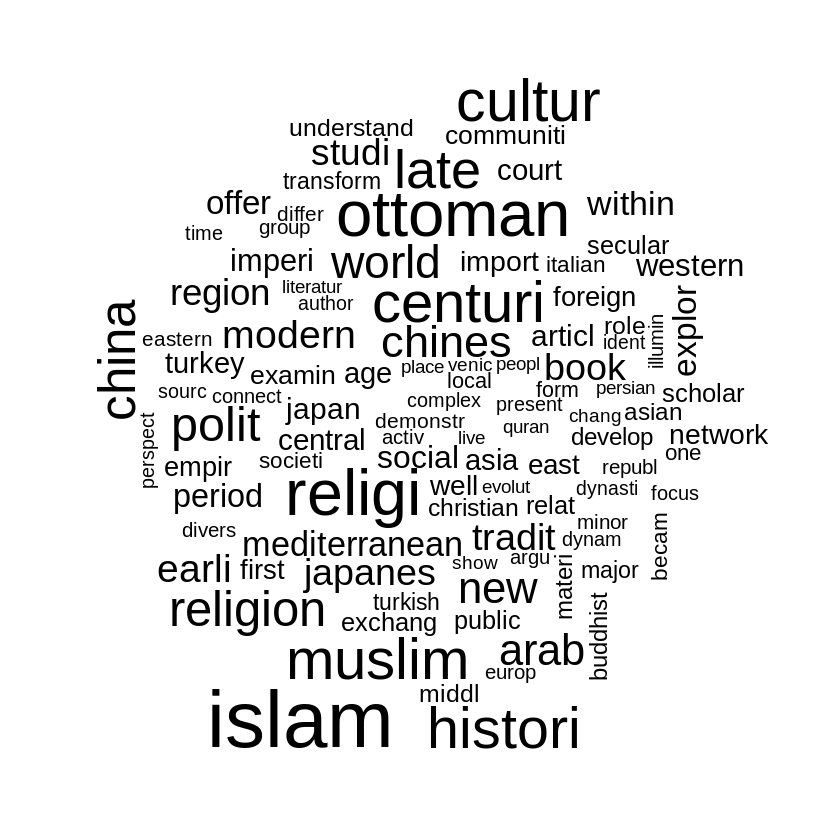

In [16]:
png(filename='../output/wordcloud.png')
cloud(model, 19, documents=docs)
dev.off()

cloud(model, 19, documents=docs)

Inspecting valid thresholds via grid search. Progress:
  |======================================================================| 100%


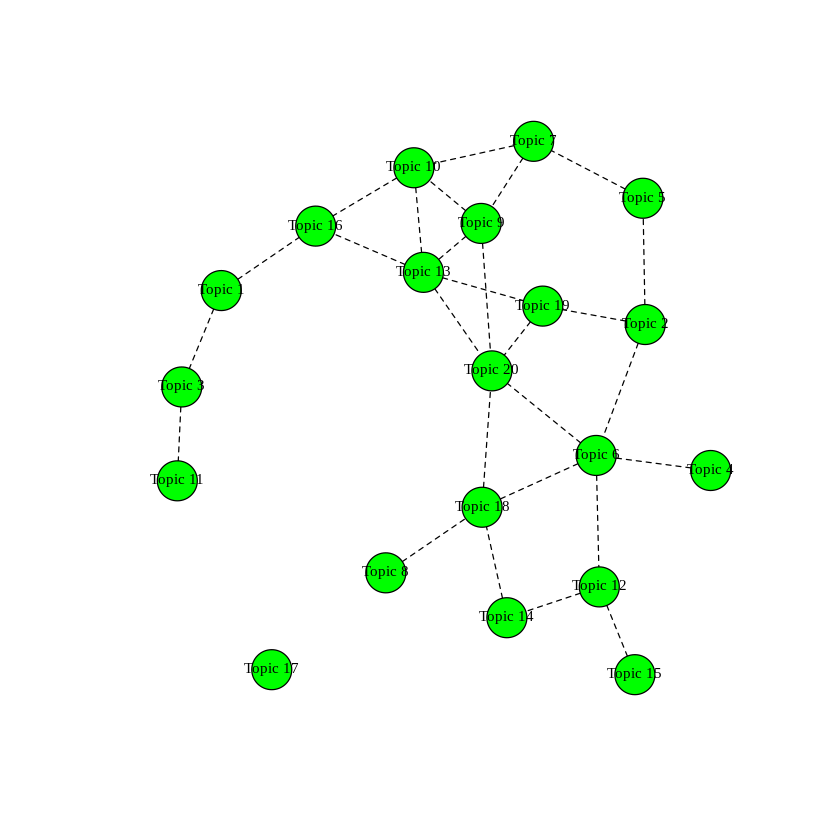

In [17]:
# Inspect topic correlations

# View this one from file:
stmCorrViz(model, 
           file_out = '../output/corrviz.html',
           documents_matrix = docs, 
           title = "Topic Correlations (k = 20)", 
           display = FALSE)

# This produces a visual:
corr = topicCorr(model)
plot(corr)

## Estimate topic relationships with gender

In [20]:
# Function for converting p.value into asterisks:
signif.num <- function(x) {
    symnum(x, corr = FALSE, na = FALSE, legend = FALSE,
           cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1), 
           symbols = c("***", "**", "*", ".", " "))
}

In [21]:
# Gender x Topics
gender_effect <- estimateEffect(~ Year + Gender,
                               model, meta = meta, uncertainty = "Global")
summary(gender_effect)


Call:
estimateEffect(formula = ~Year + Gender, stmobj = model, metadata = meta, 
    uncertainty = "Global")


Topic 1:

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.9305490  0.7113610  -4.120 3.84e-05 ***
Year         0.0014807  0.0003528   4.196 2.74e-05 ***
Gendermale   0.0102491  0.0039532   2.593  0.00955 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Topic 2:

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.2252468  0.6700109   6.306 3.03e-10 ***
Year        -0.0020743  0.0003323  -6.242 4.56e-10 ***
Gendermale  -0.0053898  0.0032131  -1.677   0.0935 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Topic 3:

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -8.6020997  0.9899921  -8.689   <2e-16 ***
Year         0.0043233  0.0004911   8.804   <2e-16 ***
Gendermale  -0.0027842  0.0051588  -0.540    0.589    
---
Signif. codes:

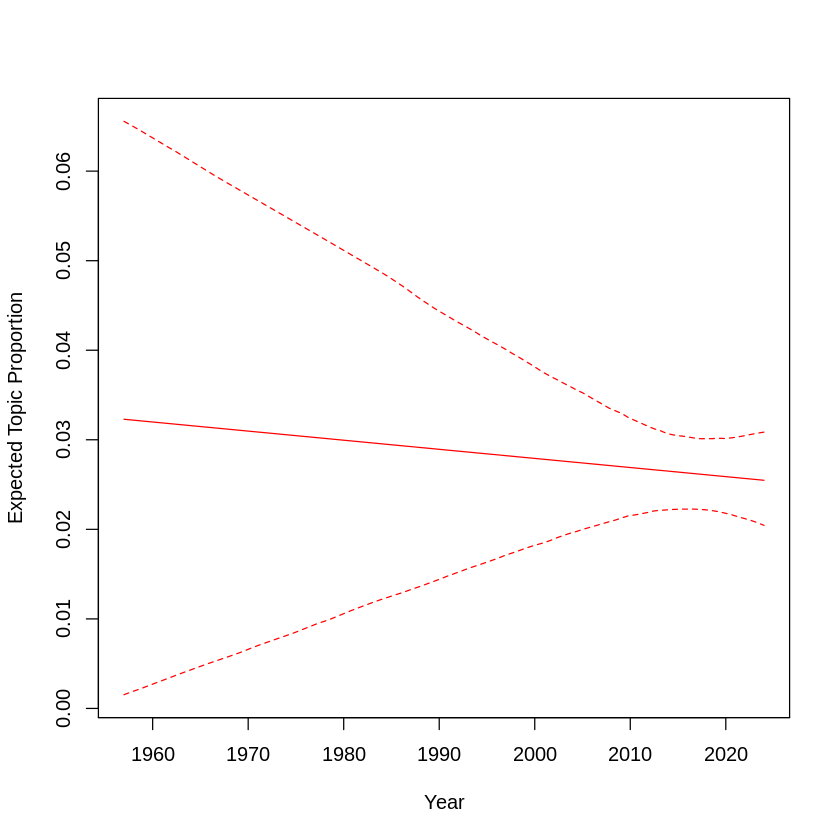

In [50]:
# Visualize topical prevalence over years
plot(gender_effect, "Year", method = "continuous", topics = 5,
     model = model, printlegend = FALSE, xlab = "Year")

yearseq <- seq(from = as.Date("1970-01-01"), to = as.Date("2023-12-01"), by = "year")
years <- year(yearseq)

axis(1, at = as.numeric(yearseq) - min(as.numeric(yearseq)), labels = years)

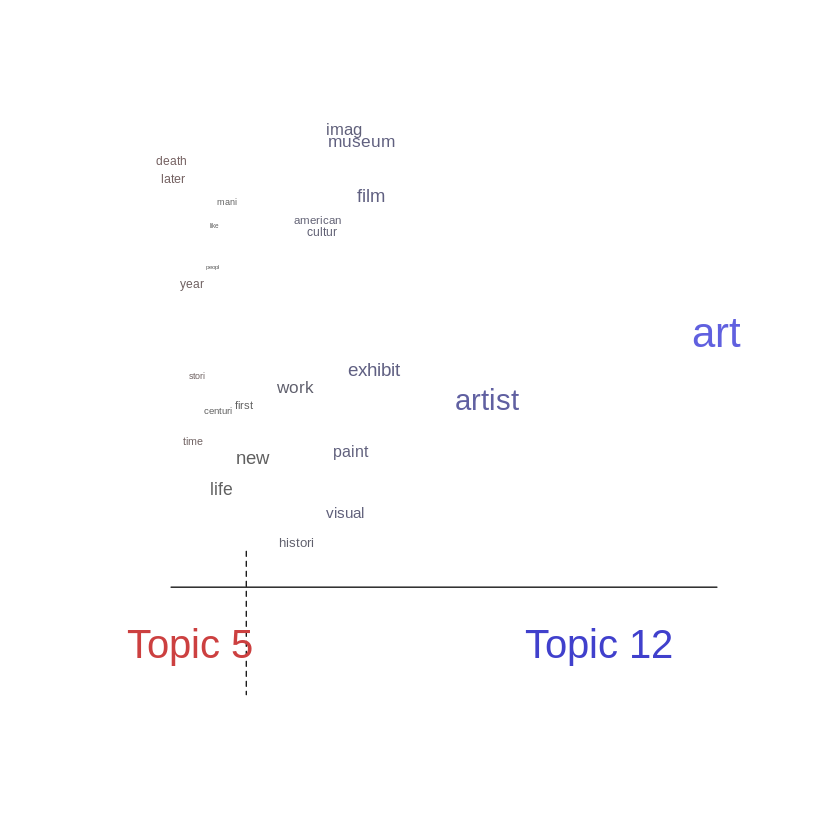

In [47]:
# Graphical display of topical contrast
plot(model, type = "perspectives", topics = c(5,12))

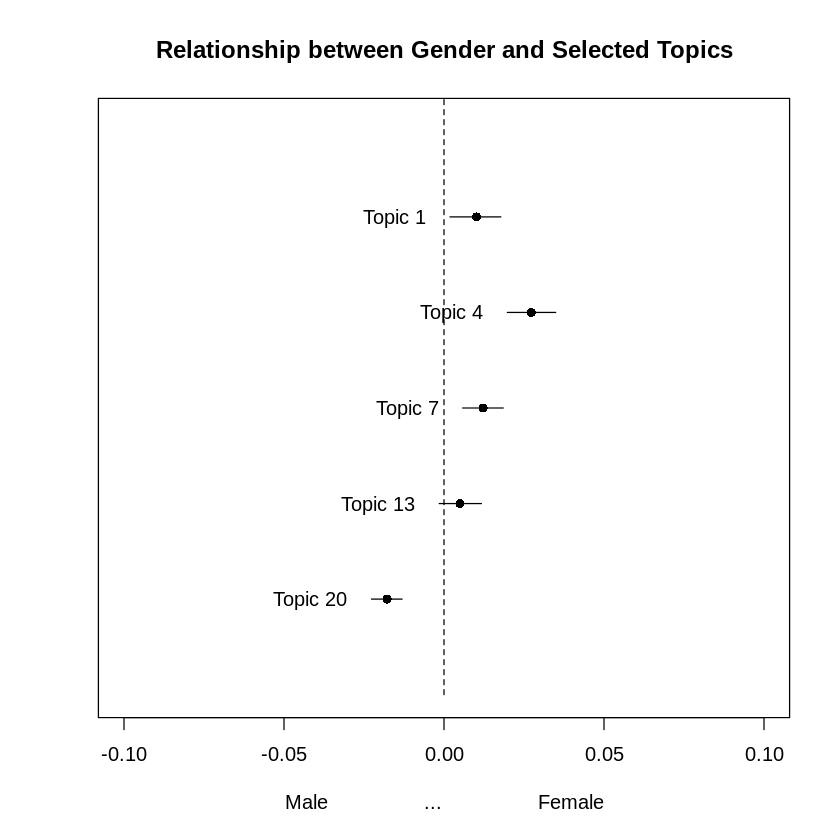

In [60]:
# Graph relationship between gender and selected topics
x2="Male                ...                Female"
title2="Relationship between Gender and Selected Topics"
legend2=c("Topic 1: A", "Topic 4: B", "Topic 7: C", "Topic 13: D", "Topic 20: E")

plot(gender_effect, covariate="Gender", topics=c(1, 4, 7, 13, 20), model=model,
     method="difference", cov.value1 = "male", cov.value2 = "female",
     xlab=x2, main=title2,
     xlim = c(-.1, .1), labeltype = "custom",
     custom.labels = c('Topic 1', 'Topic 4','Topic 7', 'Topic 13', 'Topic 20')) #, printlegend=FALSE

In [61]:
# Save to fresh CSV
tidy_frame <- tidy(gender_effect) # Tidy up output
#toDel <- seq(1, nrow(tidy_frame), 2); tidy_frame <- tidy_frame[ -toDel ,] # keep only coeffs and p.values, NO controls: Capture even rows
toKeep <- seq(2, nrow(tidy_frame), 9); tidy_frame <- tidy_frame[ toKeep,] # keep only coeffs and p.values, WITH controls: Capture every 2nd row from start in batches of 9tidy_frame$estimate <- format(tidy_frame$estimate, digits=3) # Reduce to 3 significant figurestidy_frame$estimate <- format(tidy_frame$estimate, digits=3) # Reduce estimates to three significant digits

tidy_frame$signif <- signif.num(tidy_frame$p.value) # Derive asterisks from p.value
keepcols = c("topic", "term", "estimate", "signif") # Define columns to keep

tidy_frame <- tidy_frame[keepcols] # Drop unnecessary columns
write.csv(tidy_frame,'../output/estimate_topic_effects.csv') # Save new DF to CSV
tidy_frame # Look at clean results

topic,term,estimate,signif
<int>,<chr>,<dbl>,<noquote>
1,Year,0.0014826333,***
4,Year,-0.0027382078,***
7,Year,-0.0003468263,
10,Year,0.0012644749,***
13,Year,0.0001665675,
16,Year,0.0010594074,***
19,Year,-0.0008114309,**
